<a href="https://colab.research.google.com/github/aylnakyz/NLP2025/blob/main/NLP2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
import pandas as pd
import os
import re
import string
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import nltk
from nltk.tokenize import word_tokenize

In [2]:
# Download NLTK tokenizer model
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

**Download the Datasets (En, Tr)**

Two datasets for English and Turkish available in HuggingFace and in Kaggle were used in this project to test whether Zipf's Law of Abbreviation holds for the lyrics in both English and Turkish.

In [3]:
#Download English dataset and include only the column containing lyrics.
def load_english_dataset():
    df_en = pd.read_csv("hf://datasets/brunokreiner/genius-lyrics/english_lyrics_some_with_genres.csv")     # Load English dataset through the path.
    df_en = df_en[["lyrics"]].dropna() #Include only lyrics in the English dataframe.
    df_en = df_en.sample(n=5000, random_state=42)  # Reduce dataset to 5000 rows because it has more than 480.000 lines (songs).
    return df_en

df_en = load_english_dataset()
print(df_en.head())


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


                                                   lyrics
459044  you re wondering if i care about ya or if ther...
235809  the youth have been tricked into war because t...
251156  it s never easy to see the sun when you re loc...
157506  what makes him stand and fight when he only wa...
252911  if i be so inclined to climb up beside you wou...


In [4]:
#Download Turkish dataset and include only the column containing lyrics.
def load_turkish_dataset():
    path = kagglehub.dataset_download("emreokcular/turkish-song-lyrics") #Load Turkish dataset through the kaggle path.
    dataset_files = os.listdir(path)
    print("Dataset files:", dataset_files)
    csv_file_path = os.path.join(path, 'turkish_song_lyrics.csv')
    df_tr = pd.read_csv(csv_file_path)
    df_tr = df_tr[["lyrics"]].dropna() #Include only lyrics in the Turkish dataframe.
    return df_tr

df_tr = load_turkish_dataset()
print(df_tr.head())

100%|██████████| 1.36M/1.36M [00:00<00:00, 24.6MB/s]

Extracting files...


Dataset files: ['turkish_song_lyrics.csv']
                                              lyrics
0  Bir mavi otobüs gelirdi\nSeni alır giderdi\nO ...
1  Uyusun ha iyi büyüsün,\nCamlar buğulanmasın\nS...
2  Kavuşmak özgürlükse özgürdük ikimiz de\nElleri...
3  Ada sahillerinde bekliyorum\nHer zaman yolları...
4  Geçiyor önümden, sirenler içinde\nAh eller üst...


In [5]:
#The number of songs in each dataset.
data_info = pd.DataFrame({
    'Dataset': ['English Lyrics', 'Turkish Lyrics'],
    'Number of Lines': [len(df_en), len(df_tr)]
})

# Display the table
data_info

,Dataset,Number of Lines
0,English Lyrics,5000
1,Turkish Lyrics,4975


**Preprocessing**

This process includes turning values into string, lowercasing, removing punctuations, special characters, html tags and url links.

In [6]:
# Function to clean data with URL and long token removal
def clean_data(df):
    df.loc[:, 'lyrics'] = df['lyrics'].astype(str)  # Ensure the 'lyrics' column is treated as a string
    df.loc[:, 'lyrics'] = df['lyrics'].str.lower()  # Convert to lowercase
    df.loc[:, 'lyrics'] = df['lyrics'].str.replace(f'[{string.punctuation}0-9]', '', regex=True)  # Remove punctuation, numbers
    df.loc[:, 'lyrics'] = df['lyrics'].str.replace('\n', ' ', regex=False)  # Replace newlines with spaces
    # Remove URLs
    df.loc[:, 'lyrics'] = df['lyrics'].str.replace(r'http\S+|www\S+', '', regex=True)  # Remove URLs
    # Remove tokens longer than 20 characters (if necessary)
    df.loc[:, 'lyrics'] = df['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if len(word) <= 20]))
    return df

# Apply cleaning function to both datasets
df_en_clean = clean_data(df_en)
df_tr_clean = clean_data(df_tr)

# Check cleaned data
print("Cleaned English dataset sample:")
print(df_en_clean.head())

print("Cleaned Turkish dataset sample:")
print(df_tr_clean.head())


Cleaned English dataset sample:
                                                   lyrics
459044  you re wondering if i care about ya or if ther...
235809  the youth have been tricked into war because t...
251156  it s never easy to see the sun when you re loc...
157506  what makes him stand and fight when he only wa...
252911  if i be so inclined to climb up beside you wou...
Cleaned Turkish dataset sample:
                                              lyrics
0  bir mavi otobüs gelirdi seni alır giderdi o ma...
1  uyusun ha iyi büyüsün camlar buğulanmasın sen ...
2  kavuşmak özgürlükse özgürdük ikimiz de elleri ...
3  ada sahillerinde bekliyorum her zaman yolların...
4  geçiyor önümden sirenler içinde ah eller üstün...


**Tokenization**

Spacy is used for the English dataset and multilingual spaCy is used for the Turkish dataset.

In [7]:
# Tokenization using NLTK
text_en = " ".join(df_en_clean["lyrics"])
tokens_en = word_tokenize(text_en)
print(tokens_en[:100])

text_tr = " ".join(df_tr_clean["lyrics"])
tokens_tr = word_tokenize(text_tr)
print(tokens_tr[:100])

['you', 're', 'wondering', 'if', 'i', 'care', 'about', 'ya', 'or', 'if', 'there', 's', 'some', 'cause', 'that', 'i', 'should', 'doubt', 'ya', 'oh', 'i', 'can', 'see', 'girl', 'that', 'you', 'don', 't', 'know', 'me', 'very', 'well', 'you', 're', 'so', 'unsure', 'and', 'you', 'run', 'here', 'and', 'there', 'to', 'ask', 'my', 'feelings', 'but', 'friends', 'only', 'guess', 'they', 'can', 't', 'really', 'say', 'don', 't', 'ask', 'my', 'neighbors', 'don', 't', 'ask', 'the', 'friends', 'i', 'hang', 'around', 'don', 't', 'be', 'afraid', 'to', 'come', 'to', 'me', 'don', 't', 'ask', 'my', 'neighbors', 'come', 'to', 'me', 'don', 't', 'be', 'afraid', 'you', 'ask', 'all', 'my', 'friends', 'if', 'i', 'm', 'the', 'same', 'girl', 'you']
['bir', 'mavi', 'otobüs', 'gelirdi', 'seni', 'alır', 'giderdi', 'o', 'mavi', 'otobüs', 'var', 'ya', 'seni', 'alır', 'giderdi', 'kaldırımlar', 'kaldırımlar', 'varya', 'seni', 'alır', 'giderdi', 'o', 'mavi', 'otobüs', 'varya', 'seni', 'alır', 'giderdi', 'fabrikada', 'tüt

In [8]:
# Display token counts after preprocessing to see whether there is data loss during tokenization
print("\nToken Counts After Preprocessing:")
token_counts_after = pd.DataFrame({"Dataset": ["English", "Turkish"],
                                   "Token Count": [len(tokens_en), len(tokens_tr)]})
print(token_counts_after.to_string(index=False))


Token Counts After Preprocessing:
Dataset  Token Count
English      1389137
Turkish       550199


**Calculation of word frequencies and lengths**



In [9]:
# Step 4: Calculate word frequencies and lengths
def word_stats(tokens):
    word_freq = Counter(tokens)
    word_lengths = {word: len(word) for word in word_freq}
    return word_freq, word_lengths

freq_en, length_en = word_stats(tokens_en)
freq_tr, length_tr = word_stats(tokens_tr)



In [10]:
# Function to get the most and least frequent words
def get_most_least_frequent(tokens):
    # Count the frequency of each word
    word_freq = Counter(tokens)

    # Get the 10 most common words
    most_common = word_freq.most_common(10)

    # Get the 10 least common words (excluding those with 0 frequency)
    least_common = word_freq.most_common()[-10:]

    return most_common, least_common

# For English dataset
most_common_en, least_common_en = get_most_least_frequent(tokens_en)

# For Turkish dataset
most_common_tr, least_common_tr = get_most_least_frequent(tokens_tr)

# Print the results
print("10 Most Frequent Words in English Dataset:")
for word, freq in most_common_en:
    print(f"{word}: {freq}")

print("\n10 Least Frequent Words in English Dataset:")
for word, freq in least_common_en:
    print(f"{word}: {freq}")

print("\n10 Most Frequent Words in Turkish Dataset:")
for word, freq in most_common_tr:
    print(f"{word}: {freq}")

print("\n10 Least Frequent Words in Turkish Dataset:")
for word, freq in least_common_tr:
    print(f"{word}: {freq}")


10 Most Frequent Words in English Dataset:
i: 64027
the: 51588
you: 49916
and: 29447
to: 28403
a: 26097
it: 24149
me: 20883
my: 19106
t: 18329

10 Least Frequent Words in English Dataset:
ruffnecks: 1
ammonia: 1
sayer: 1
edit: 1
materialize: 1
strolls: 1
spew: 1
vaginal: 1
turfies: 1
discontentment: 1

10 Most Frequent Words in Turkish Dataset:
bir: 12873
bu: 6547
ben: 4804
ne: 4738
sen: 4116
beni: 3777
de: 3443
her: 3352
ve: 2955
gibi: 2802

10 Least Frequent Words in Turkish Dataset:
güldünüz: 1
dertleşmeye: 1
yemeğim: 1
televizyonun: 1
keşfetti: 1
girebilen: 1
uğraşmak: 1
hazırcı: 1
eskimek: 1
bedensin: 1


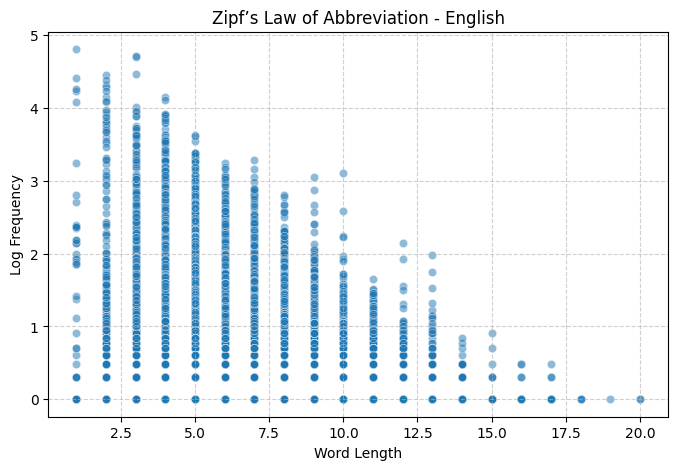

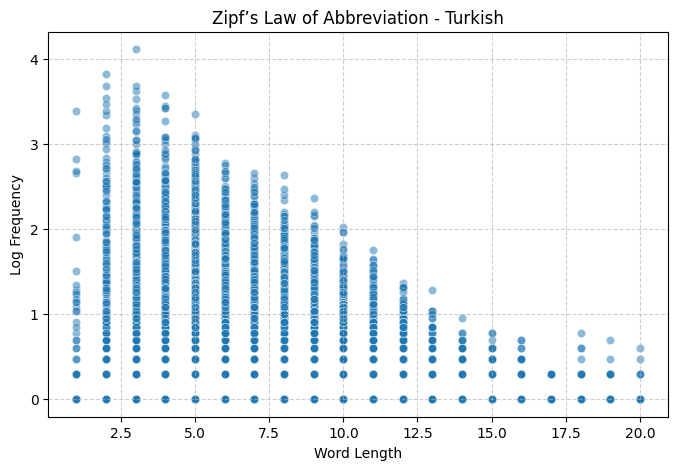

In [13]:
# Function to compute word frequencies and lengths
def get_word_stats(df):
    words = ' '.join(df['lyrics']).split()
    word_counts = Counter(words)
    word_lengths = {word: len(word) for word in word_counts.keys()}
    df_stats = pd.DataFrame({
        'word': list(word_counts.keys()),
        'frequency': list(word_counts.values()),
        'length': [word_lengths[word] for word in word_counts.keys()]
    })
    df_stats['log_frequency'] = np.log10(df_stats['frequency'])
    return df_stats

# Compute statistics for English and Turkish datasets
df_en_stats = get_word_stats(df_en)
df_tr_stats = get_word_stats(df_tr)

# Plot function
def plot_zipf_dotplot(df_stats, language):
    plt.figure(figsize=(8, 5))
    sns.scatterplot(x=df_stats['length'], y=df_stats['log_frequency'], alpha=0.5)
    plt.xlabel('Word Length')
    plt.ylabel('Log Frequency')
    plt.title(f'Zipf’s Law of Abbreviation - {language}')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

# Generate plots
plot_zipf_dotplot(df_en_stats, 'English')
plot_zipf_dotplot(df_tr_stats, 'Turkish')


**Visualizations for Zipf's Law of Abbreviation**


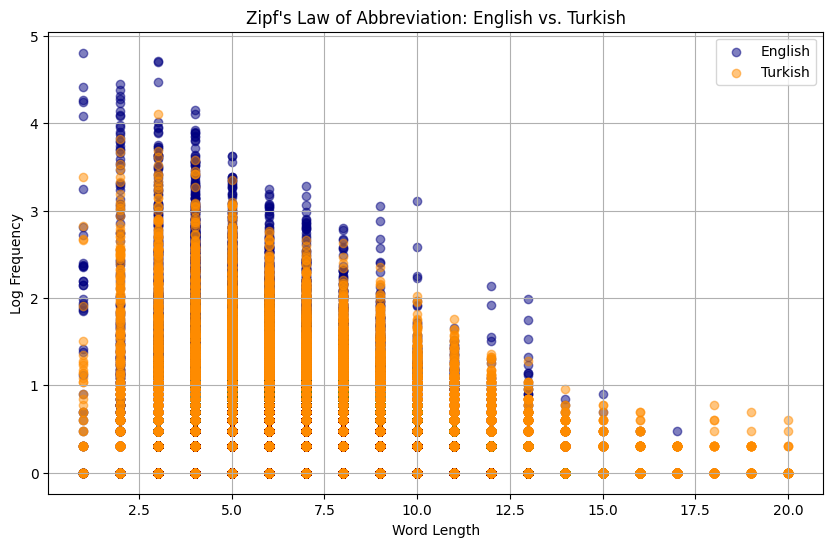

In [14]:


# Function to compute word frequencies and lengths
def get_word_stats(df):
    words = ' '.join(df['lyrics']).split()
    word_counts = Counter(words)
    word_lengths = {word: len(word) for word in word_counts.keys()}
    df_stats = pd.DataFrame({
        'word': list(word_counts.keys()),
        'frequency': list(word_counts.values()),
        'length': [word_lengths[word] for word in word_counts.keys()]
    })
    df_stats['log_frequency'] = np.log10(df_stats['frequency'])
    return df_stats

# Compute statistics for English and Turkish datasets
df_en_stats = get_word_stats(df_en)
df_tr_stats = get_word_stats(df_tr)

# Function to plot Zipf's Law of Abbreviation in one graph
def plot_zipf_abbreviation(df_stats_en, df_stats_tr):
    plt.figure(figsize=(10, 6))
    plt.scatter(df_stats_en['length'], df_stats_en['log_frequency'], color='navy', alpha=0.5, label="English")
    plt.scatter(df_stats_tr['length'], df_stats_tr['log_frequency'], color='darkorange', alpha=0.5, label="Turkish")

    plt.xlabel("Word Length")
    plt.ylabel("Log Frequency")
    plt.title("Zipf's Law of Abbreviation: English vs. Turkish")
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate plot
plot_zipf_abbreviation(df_en_stats, df_tr_stats)


**Visualization for Zipf's Law of Power**

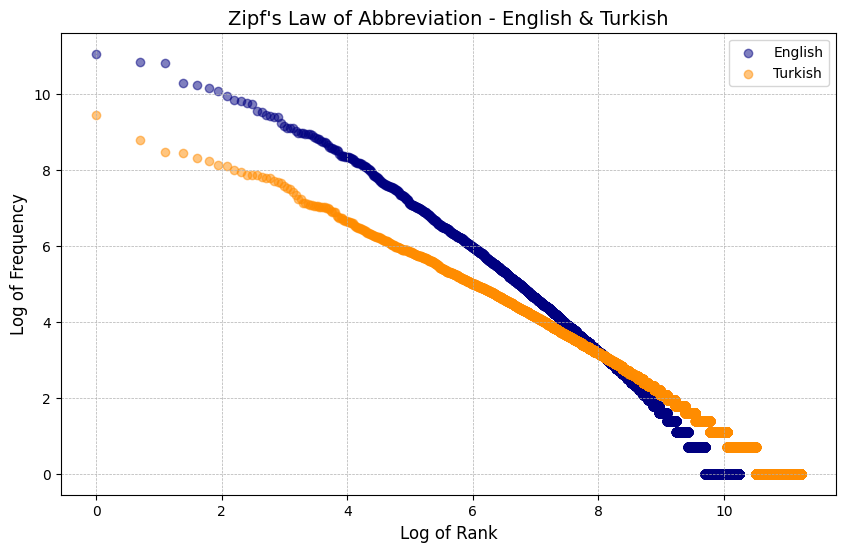

In [15]:
# Function to calculate frequency of words
def calculate_word_frequencies(tokens):
    word_counts = Counter(tokens)  # Count word frequencies
    sorted_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)  # Sort by frequency
    return sorted_counts

# Function to plot a combined log-log graph for both languages
def plot_zipf_log_log(sorted_counts_en, sorted_counts_tr):
    ranks_en = np.arange(1, len(sorted_counts_en) + 1)  # Rank of words in English
    frequencies_en = [count for word, count in sorted_counts_en]  # Frequencies in English

    ranks_tr = np.arange(1, len(sorted_counts_tr) + 1)  # Rank of words in Turkish
    frequencies_tr = [count for word, count in sorted_counts_tr]  # Frequencies in Turkish

    # Plotting the log-log graph
    plt.figure(figsize=(10, 6))
    plt.scatter(np.log(ranks_en), np.log(frequencies_en), color='navy', alpha=0.5, label='English')
    plt.scatter(np.log(ranks_tr), np.log(frequencies_tr), color='darkorange', alpha=0.5, label='Turkish')

    plt.title("Zipf's Law of Abbreviation - English & Turkish", fontsize=14)
    plt.xlabel('Log of Rank', fontsize=12)
    plt.ylabel('Log of Frequency', fontsize=12)
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.legend()
    plt.show()

# Calculate frequencies
sorted_counts_en = calculate_word_frequencies(tokens_en)
sorted_counts_tr = calculate_word_frequencies(tokens_tr)

# Plot combined graph
plot_zipf_log_log(sorted_counts_en, sorted_counts_tr)
